In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load images

In [3]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031464.959763.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

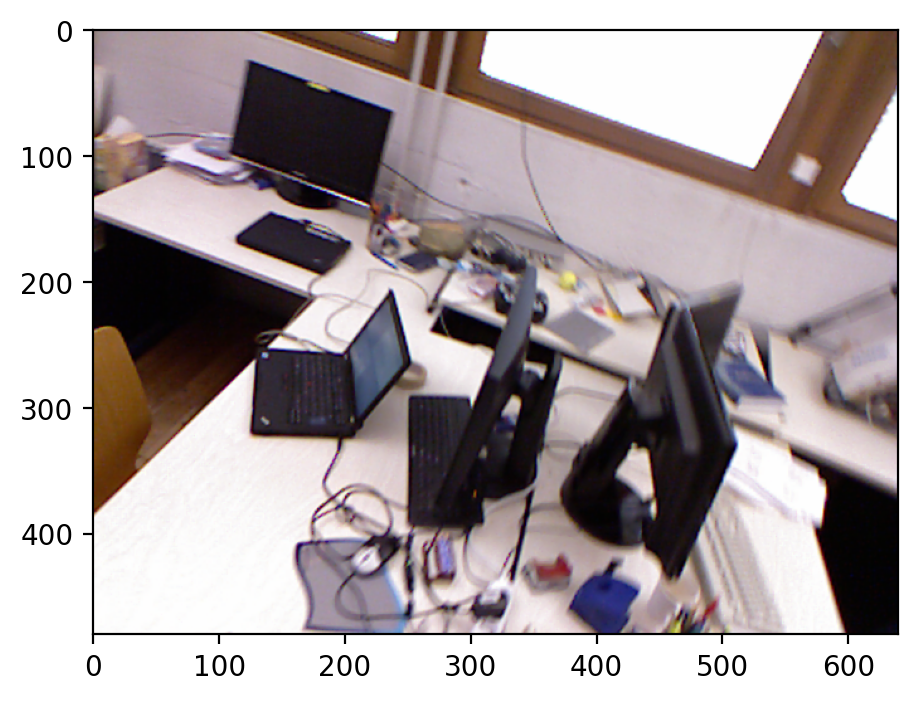

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

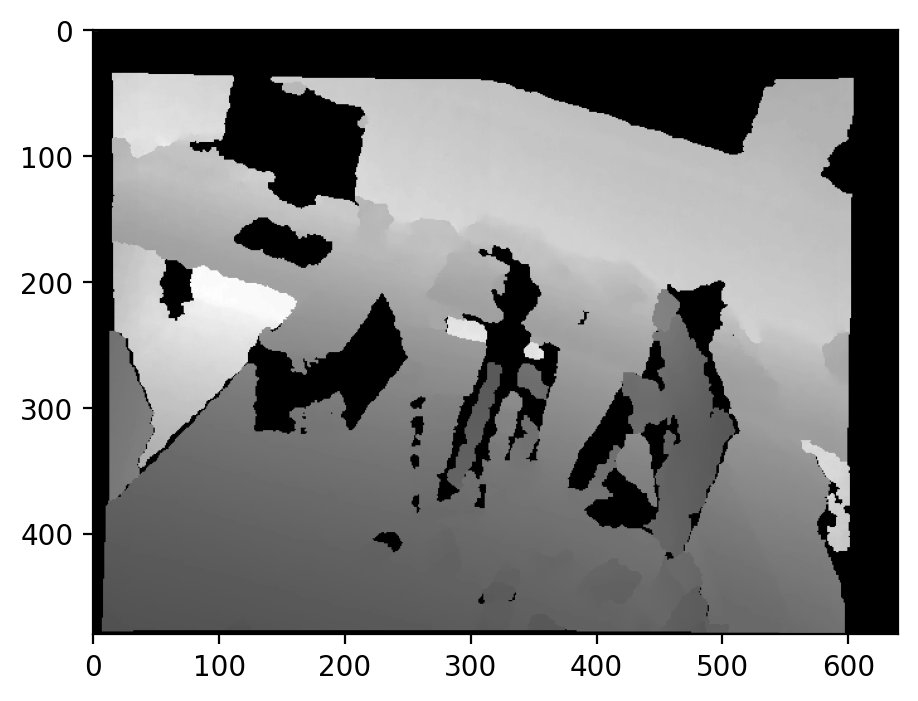

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [6]:
dataset_params = {'dataset_path': "/media/mikhail/Data3T/tum_rgbd", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [66]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01,
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

# Test map builder

In [67]:
from imap.slam.imap_data_loader import IMAPDataLoader
from imap.slam.active_sampler import ActiveSampler
from imap.slam.keyframe_validator import KeyframeValidator
from imap.slam.imap_map_builder import IMAPMapBuilder
from imap.data.tum_frame_loader import TUMFrameLoader
from imap.slam.optimized_frame import OptimizedFrame

In [68]:
dataset_path = "/media/mikhail/Data3T/tum_rgbd"
scene_name = "rgbd_dataset_freiburg1_desk"
association_file_name = "data_association_file.txt"
camera_info = data_module._dataset._camera_info
map_builder_data_loader = IMAPDataLoader(50, 200, camera_info)

sampler_data_loader = IMAPDataLoader(1, 200, camera_info)
sampler = ActiveSampler(sampler_data_loader, 4, 1)

keyframe_validator = KeyframeValidator(0.1, 0.5)
builder = IMAPMapBuilder(model, map_builder_data_loader, sampler, keyframe_validator)
frames = TUMFrameLoader(dataset_path, scene_name, association_file_name, range(0, 500, 1))

initial_position = np.eye(4)[:3, :]
frames = [OptimizedFrame(x, initial_position) for x in frames]

Reading /media/mikhail/Data3T/tum_rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [69]:
previous_frame = frames[0]
previous_frame.position.requires_grad_(False)
builder.set_current_frame(previous_frame)
builder.step()
for frame in tqdm(frames[1:]):
    frame.position.data = previous_frame.position.detach().clone().requires_grad_(True)
    builder.set_current_frame(frame)
    builder.step()
    previous_frame = frame

Map builder step
Start training
Final loss = 0.7963747978210449
Keyframe validator criterion = 0.42857142857142855
Keyframe is validated = True


  0%|          | 0/499 [00:00<?, ?it/s]

Map builder step
Start training
Final loss = 0.620890736579895
Keyframe validator criterion = 0.4879518072289157
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.549612283706665
Keyframe validator criterion = 0.4146341463414634
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5253946781158447
Keyframe validator criterion = 0.49056603773584906
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.4632410407066345
Keyframe validator criterion = 0.5868263473053892
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4791876971721649
Keyframe validator criterion = 0.524390243902439
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4265598952770233
Keyframe validator criterion = 0.5064102564102564
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.43773749470710754
Keyframe validator criterion = 0.5818181818181818
Keyframe is validated = Fa

Final loss = 0.42219215631484985
Keyframe validator criterion = 0.62
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.36271873116493225
Keyframe validator criterion = 0.6959459459459459
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.3872968852519989
Keyframe validator criterion = 0.78
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.34515777230262756
Keyframe validator criterion = 0.6493506493506493
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.37001660466194153
Keyframe validator criterion = 0.6754966887417219
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.3714390695095062
Keyframe validator criterion = 0.6560509554140127
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4193815588951111
Keyframe validator criterion = 0.6382978723404256
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.3

Final loss = 0.36841878294944763
Keyframe validator criterion = 0.5170068027210885
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4032925069332123
Keyframe validator criterion = 0.6
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.39944955706596375
Keyframe validator criterion = 0.6265822784810127
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.3515988290309906
Keyframe validator criterion = 0.632258064516129
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.3409677743911743
Keyframe validator criterion = 0.6180555555555556
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.41281479597091675
Keyframe validator criterion = 0.654320987654321
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.39002227783203125
Keyframe validator criterion = 0.6308724832214765
Keyframe is validated = False
Map builder step
Start training
Final

Final loss = 0.4574700891971588
Keyframe validator criterion = 0.6453900709219859
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.46924683451652527
Keyframe validator criterion = 0.6056338028169014
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.48463624715805054
Keyframe validator criterion = 0.5538461538461539
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5023432970046997
Keyframe validator criterion = 0.6518518518518519
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.49256160855293274
Keyframe validator criterion = 0.5606060606060606
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4909990429878235
Keyframe validator criterion = 0.6853146853146853
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4272473156452179
Keyframe validator criterion = 0.625
Keyframe is validated = False
Map builder step
Start training
Fi

Final loss = 0.4245249927043915
Keyframe validator criterion = 0.6016260162601627
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.47308310866355896
Keyframe validator criterion = 0.6532258064516129
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4759654402732849
Keyframe validator criterion = 0.5158730158730159
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.44600561261177063
Keyframe validator criterion = 0.6102941176470589
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4258933663368225
Keyframe validator criterion = 0.656934306569343
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5810793042182922
Keyframe validator criterion = 0.7210884353741497
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5313555002212524
Keyframe validator criterion = 0.5454545454545454
Keyframe is validated = False
Map builder step
Start 

Final loss = 0.466013640165329
Keyframe validator criterion = 0.782608695652174
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5793582201004028
Keyframe validator criterion = 0.7266666666666667
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.43173834681510925
Keyframe validator criterion = 0.7272727272727273
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4262290596961975
Keyframe validator criterion = 0.6666666666666666
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5344095230102539
Keyframe validator criterion = 0.6178343949044586
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4356866478919983
Keyframe validator criterion = 0.6274509803921569
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.48657676577568054
Keyframe validator criterion = 0.7070063694267515
Keyframe is validated = False
Map builder step
Start t

Final loss = 0.6489499807357788
Keyframe validator criterion = 0.4966442953020134
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.4351019263267517
Keyframe validator criterion = 0.5947712418300654
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5882145166397095
Keyframe validator criterion = 0.5369127516778524
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5005413889884949
Keyframe validator criterion = 0.5238095238095238
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5213472247123718
Keyframe validator criterion = 0.496551724137931
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.58656245470047
Keyframe validator criterion = 0.46308724832214765
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.43650075793266296
Keyframe validator criterion = 0.44966442953020136
Keyframe is validated = True
Map builder step
Start train

Final loss = 0.5248244404792786
Keyframe validator criterion = 0.4563758389261745
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.37808117270469666
Keyframe validator criterion = 0.4589041095890411
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5586162805557251
Keyframe validator criterion = 0.4805194805194805
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5663073062896729
Keyframe validator criterion = 0.3533834586466165
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.47209611535072327
Keyframe validator criterion = 0.4117647058823529
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.3888615071773529
Keyframe validator criterion = 0.48936170212765956
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5716437697410583
Keyframe validator criterion = 0.36666666666666664
Keyframe is validated = True
Map builder step
Start trai

Final loss = 0.45875999331474304
Keyframe validator criterion = 0.48175182481751827
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.46592846512794495
Keyframe validator criterion = 0.47333333333333333
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.49925023317337036
Keyframe validator criterion = 0.4966442953020134
Keyframe is validated = True
Map builder step
Start training
Final loss = 0.5814401507377625
Keyframe validator criterion = 0.5345911949685535
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.47470328211784363
Keyframe validator criterion = 0.5067567567567568
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.5067955255508423
Keyframe validator criterion = 0.6
Keyframe is validated = False
Map builder step
Start training
Final loss = 0.4695066809654236
Keyframe validator criterion = 0.47770700636942676
Keyframe is validated = True
Map builder step
Start training
Fina

In [72]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.show()



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

In [75]:
ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
rotation = ground_truth_trajectory[0, :3, :3]
ground_truth_trajectory[:, :3, :3] = rotation @ ground_truth_trajectory[:, :3, :3]
ground_truth_trajectory[:, :3, 3:4] = rotation @ (
    ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
predicted_trajectory = np.array([x.matrix_position[:3, 3] for x in frames])

In [76]:
show_trajectories(ground_truth_trajectory[:, :3, 3], predicted_trajectory)

In [77]:
np.sqrt(np.mean((ground_truth_trajectory[:, :3, 3] - predicted_trajectory) ** 2)) * 1000

71.90364599227905

# Show the results

In [78]:
from scipy.spatial.transform import Rotation

In [79]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [115]:
scale = 1
y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
pixels = np.array([x, y], dtype=np.float32).T * scale
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
# position = data_module._dataset._positions[0]
position = frames[0].matrix_position
# delta_position = get_position(np.array([0, 0, -1]), np.array([0.3, 0, 0]))
delta_position = get_position(np.array([0, 0, -0.05]), np.array([0, 0.5, 0]))
# position = position @ delta_position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

In [116]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
# model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

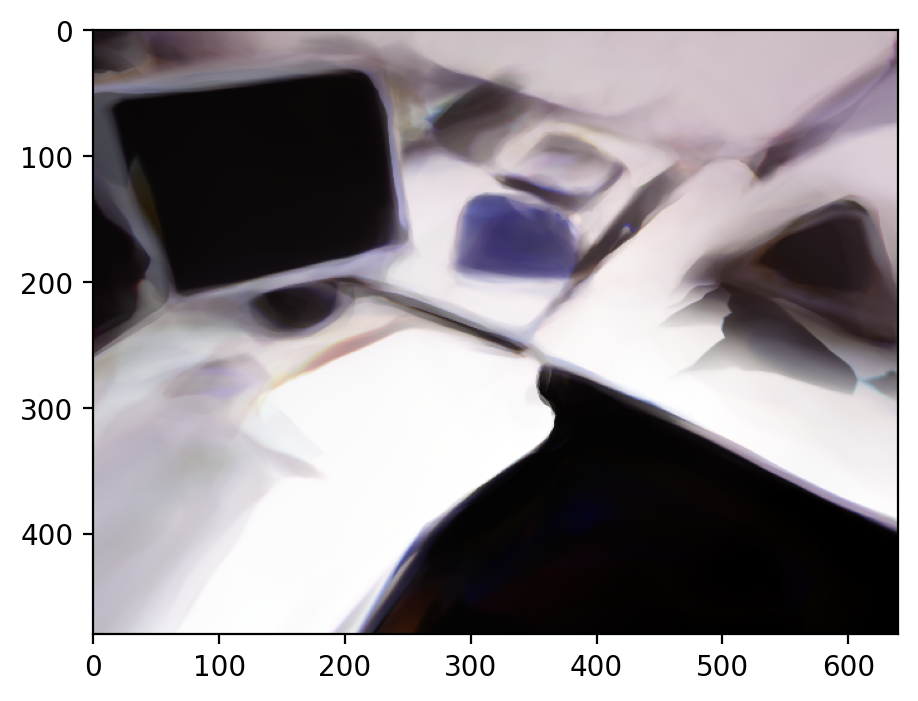

In [117]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

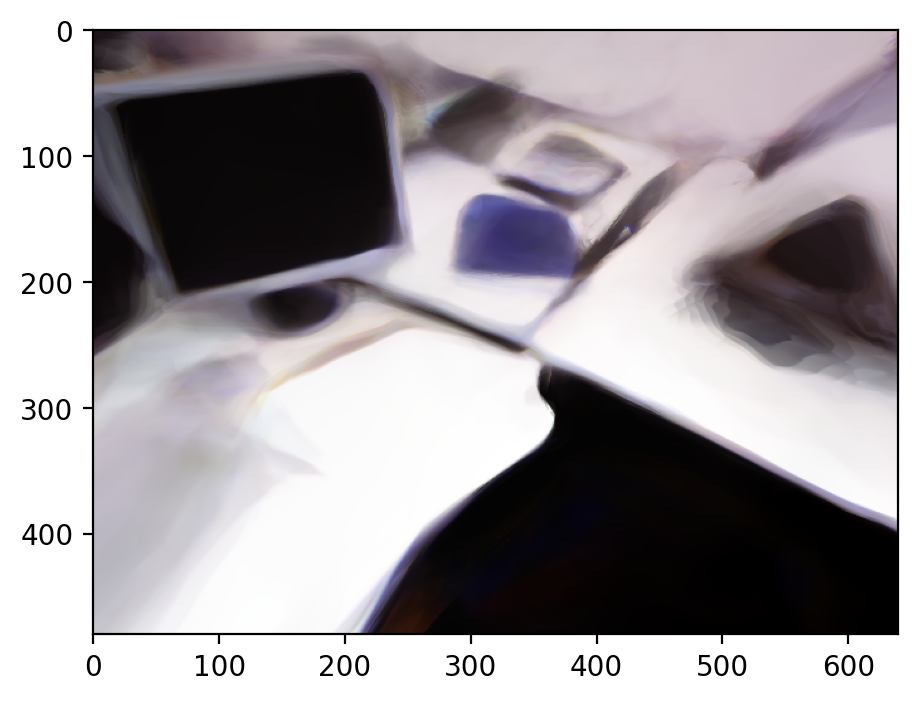

In [118]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

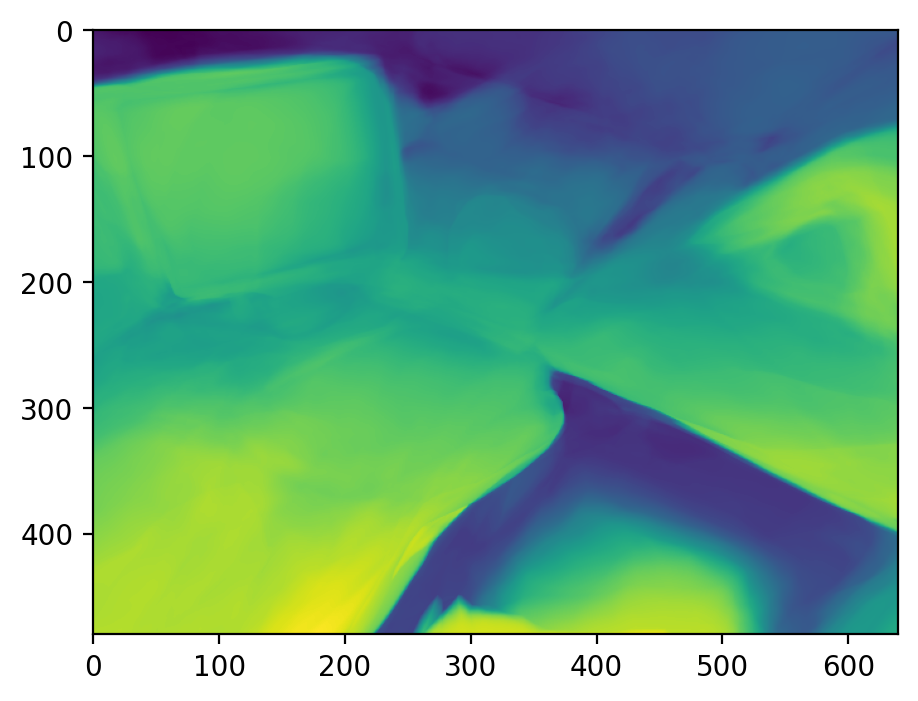

In [119]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

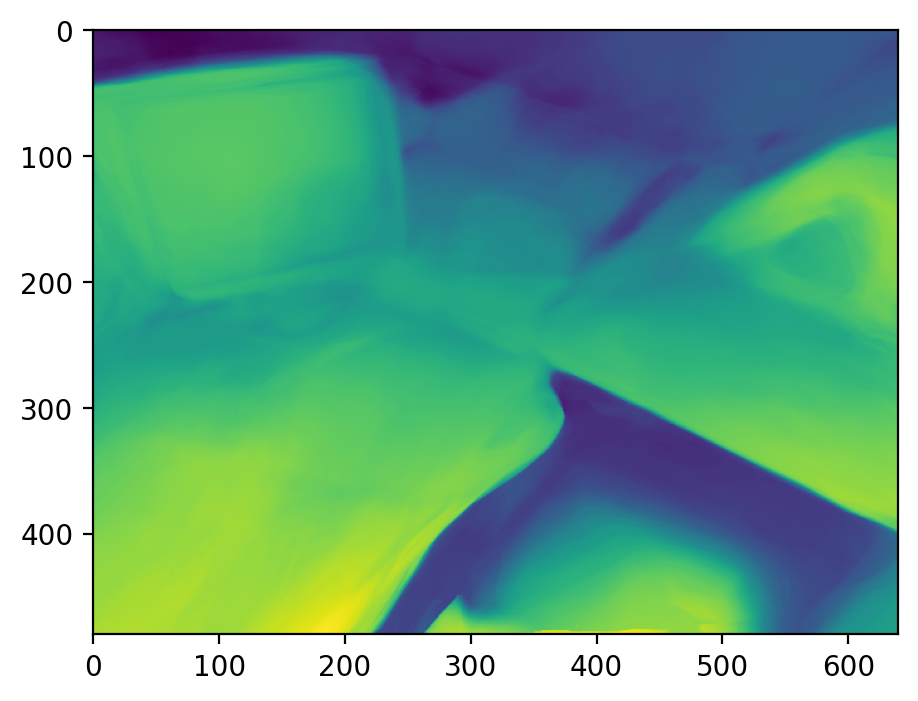

In [120]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)